In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd

from config import Config
from img_util import show_img_tensor_CHW
from img_comment_dataset import ImgCommentDataset
from fliker_data_source import load_fliker_data_items
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from common_util import get_logger
logger = get_logger(__name__)

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config()
fliker_data_items = load_fliker_data_items(config=config)
logger.info(len(fliker_data_items))

2024-09-29 12:08:42,429 - __main__ - INFO - 158915


In [12]:
# config = Config()

# img_comments_file = (
#     config.fliker_img_comments_foxlder / "results.csv"
# )  # /Users/chengbai/ml/dataset/flickr30k_images/results.csv
# imgs_folder = (
#     config.fliker_img_comments_folder / "flickr30k_images"
# )  # /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images

# list(imgs_folder.glob("*.jpg"))[:2]

In [13]:
# # The current `results.csv` file is using "| " to seperate 3 columns.
# # For the pd.read_csv, the `sep` here is given as a regular expression.
# df = pd.read_csv(img_comments_file, sep="|", index_col=False)
# df = df.astype({"image_name": "str", "comment_number": int, "comment": str})
# df1 = df[0:1]
# list(df1["image_name"]), df1["image_name"][0]

In [3]:
train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset = ImgCommentDataset(config, split="test")
logger.info(
    f"train_dataset: {len(train_dataset)}, eval_dataset: {len(eval_dataset)}, test_dataset: {len(test_dataset)}"
)

2024-09-29 12:08:49,402 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-09-29 12:08:51,272 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-09-29 12:08:57,689 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.
2024-09-29 12:09:05,853 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-09-29 12:09:07,934 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-09-29 12:09:13,974 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.
2024-09-29 12:09:22,345 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-09-29 12:09:24,216 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-09-29 12:09:30,910 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.


--- Logging error ---
Traceback (most recent call last):
  File "/opt/anaconda3/envs/torch/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/torch/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/torch/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/torch/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/torch/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  F

In [4]:
train_dataset.img_comments_df

,source,image_name,comment_number,comment,image_id
0,fliker30k,/Users/chengbai/ml/dataset/flickr30k_images/fl...,0,Two young guys with shaggy hair look at their ...,0
1,fliker30k,/Users/chengbai/ml/dataset/flickr30k_images/fl...,1,"Two young , White males are outside near many ...",0
2,fliker30k,/Users/chengbai/ml/dataset/flickr30k_images/fl...,2,Two men in green shirts are standing in a yard .,0
3,fliker30k,/Users/chengbai/ml/dataset/flickr30k_images/fl...,3,A man in a blue shirt standing in a garden .,0
4,fliker30k,/Users/chengbai/ml/dataset/flickr30k_images/fl...,4,Two friends enjoy time spent together .,0
...,...,...,...,...,...
1093821,visual_genome,/Users/chengbai/ml/dataset/visual_genome/23710...,2371055,THE CABINETS ARE YELLOW,2371055
1093822,visual_genome,/Users/chengbai/ml/dataset/visual_genome/23710...,2371055,THE TILE IS ON THE WALL,2371055
1093823,visual_genome,/Users/chengbai/ml/dataset/visual_genome/23710...,2371055,THE HANDLES ARE SILVER,2371055
1093824,visual_genome,/Users/chengbai/ml/dataset/visual_genome/23710...,2371055,man is in the kitchen,2371055


In [5]:
for df_file, df in [
    ("/tmp/train_df.csv", train_dataset.img_comments_df),
    ("/tmp/train_df.csv", train_dataset.img_comments_df),
    ("/tmp/train_df.csv", train_dataset.img_comments_df),
]:
    df.to_csv(df_file, sep="\t")
    logger.info(f"df_file: {df_file}")

2024-09-29 12:12:28,942 - __main__ - INFO - train_df_file: /tmp/train_df.csv


In [16]:
# train_dataset.cache_data()
# eval_dataset.cache_data()
# test_dataset.cache_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.704672..2.0036967].


tokens: 10000
tokenizer.is_fast: True


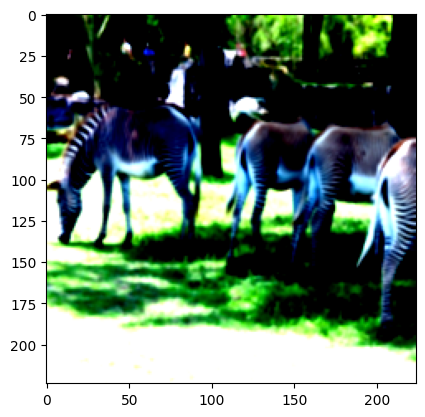

In [17]:
img_aug_tensor1, img_aug_tensor2, img_id_tensor, comment_encoding, comment_mask = (
    train_dataset[-1]
)
show_img_tensor_CHW(img_aug_tensor1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5586877..1.8947908].


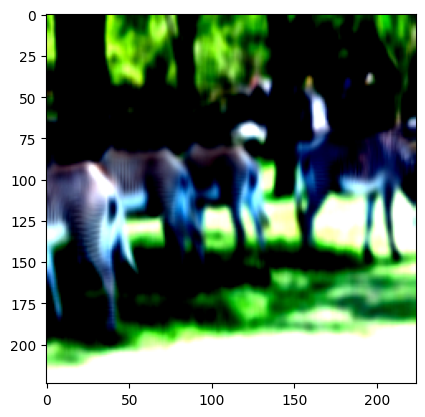

In [18]:
show_img_tensor_CHW(img_aug_tensor2)

In [19]:
# Data Loader
BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
# for batch_data in train_dataloader:
#     logger.info(train_dataloader)
#     break
(
    batch_img_aug_tensor1,
    batch_img_aug_tensor2,
    batch_img_id_tensors,
    batch_text_encodings,
    batch_text_masks,
) = next(iter(train_dataloader))
logger.info(f"batch_img_aug_tensor1: {batch_img_aug_tensor1.size()}")
logger.info(f"batch_img_aug_tensor2: {batch_img_aug_tensor2.size()}")
logger.info(f"batch_img_id_tensors: {batch_img_id_tensors.size()}")
logger.info(f"batch_text_encodings: {batch_text_encodings.size()}")
logger.info(f"batch_text_masks: {batch_text_masks.size()}")

batch_img_aug_tensor1: torch.Size([2, 3, 224, 224])
batch_img_aug_tensor2: torch.Size([2, 3, 224, 224])
batch_img_id_tensors: torch.Size([2])
batch_text_encodings: torch.Size([2, 50])
batch_text_masks: torch.Size([2, 50])


In [30]:
target_text_mask_tensor = torch.randn(size=(20, 50))
input_max, max_indices = torch.max(target_text_mask_tensor, dim=1, keepdim=False)
for v in input_max:
    logger.info(v)

tensor(2.3787)
tensor(2.4953)
tensor(2.1391)
tensor(2.2481)
tensor(2.3275)
tensor(1.9654)
tensor(1.5470)
tensor(2.5736)
tensor(2.2543)
tensor(2.7320)
tensor(2.2011)
tensor(2.5759)
tensor(2.4821)
tensor(2.3435)
tensor(1.8332)
tensor(2.1828)
tensor(2.4545)
tensor(2.1299)
tensor(2.7827)
tensor(3.4981)


In [28]:
len(target_text_tokens)

2

In [31]:
max_indices

tensor([15, 42, 15, 33, 11, 44, 48, 27, 41, 36, 41, 49, 46, 45, 13, 44, 42, 17,
         1,  7])